#### Business Objective: What was the impact of the COVID-19 pandemic on the level of home court advantage?
- Question 1: How has the difference in win-loss ratio between home and away teams changed from the 2019-20 season to the 2022-23 season? (wl_home and wl_away columns in game table)
- Question 2: How has the difference in average points scored between home and away teams changed from the 2019-20 season to the 2022-23 season? (pts_home and pts_away columns in game table)
- Question 3: How has the difference in offensive and defensive rebounds between home and away teams changed from 2019-20 to 2022-23?(oreb_home, oreb_away, dreb_home, dreb_away in the game table)
- Question 4: How does the average number of three-point field goals made by home teams compare to that of away teams from the 2019-20 season to the 2022-23 season? (fg3_pct_home and fg3_pct_away columns in game table)
- Question 5: How does the free throw percentage of home teams compare to that of away teams from the 2019-20 season to the 2022-23 season? (ft_pct_home and ft_pct_away in the game table)

In [ ]:
!pip install seaborn

In [71]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

con = sqlite3.connect("data/nba.sqlite")

seasons = ['2019', '2020', '2021', '2022']

Question 1

Intro: During the 2020-21 and 2021-22 NBA seasons, the league put COVID-19 restrictions in place to protect players and fans from infection while still allowing for some games to be played. These restrictions included playing the second half of the 2020-21 season in a bubble and playing the entirity of the 2021-22 season behind closed doors without fans. The league requested that our team conduct an analysis to determine the impact of those restrictions on the level of home court advantage, including whether any impact recovered following the lifting of those restrictions.

Rising Action: The first statistic we reviewed was the difference in win-loss ratio between home and away teams. In the 2019-20 season, the home team won 55.1% of games while the away team won 44.8%. While this does indicate a definite advantage towards the home team, the away team still has a decent chance of winning. This season was the last "normal" season before COVID, with the 2020-21 season cut short and resumed in a bubble and the 2021-22 season played without spectators in the team's usual arenas. While those restrictions would be assumed to have a significant impact on the win-loss ratio, our findings did not support that assumption.

Climax: In the 2020-21 and 2021-22 seasons, the home team win-loss ratio decreased slightly to 54.3% and 54.4% respectively. However, that decrease is not significant enough to support the assumption described above (note: need a hypothesis test to confirm). Similarly, while the away team win-loss ratio increased slightly to 45.6% in both seasons that decrease is not significant enough to indicate a shift in home court advantage (note: need a hypothesis test to confirm). Home teams still had a significant advantage over away teams, regardless of whether the game was played without fans or in a bubble.

Falling Action: While the 2020-21 and 2021-22 seasons did not include a significant change in the magnitude of home court advantage, the 2022-23 season may have. The home team win-loss ratio increased by 3.6 points to 58% (note: need a hypothesis test to confirm). This may be due to spectators returning to arenas following the lifting of most COVID restrictions. Alternatively, this may be due to away teams being less used to home fans.

Conclusion: The COVID restrictions during the 2020-21 and 2021-22 seasons do not appear to have had a significant impact on home court advantage as measured by the difference in win-loss ratio between home and away teams.

In [72]:
covid_wl_home = pd.read_sql_query("SELECT team_name_home, wl_home, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) ORDER BY season_id DESC", con)
covid_wl_home = covid_wl_home.replace('W', 1)
covid_wl_home = covid_wl_home.replace('L', 0)

covid_wl_home_group = covid_wl_home.groupby(['season_id']).agg({'wl_home': ['mean']})
covid_wl_home_group

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3688947812.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_wl_home = covid_wl_home.replace('L', 0)


,wl_home
,mean
season_id,
22019,0.551464
22020,0.543519
22021,0.543902
22022,0.580488


In [73]:
covid_wl_away = pd.read_sql_query("SELECT team_name_away, wl_away, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) ORDER BY season_id DESC", con)
covid_wl_away = covid_wl_away.replace('W', 1)
covid_wl_away = covid_wl_away.replace('L', 0)

covid_wl_away_group = covid_wl_away.groupby(['season_id']).agg({'wl_away': ['mean']})
covid_wl_away_group

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\734295079.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_wl_away = covid_wl_away.replace('L', 0)


,wl_away
,mean
season_id,
22019,0.448536
22020,0.456481
22021,0.456098
22022,0.419512


C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3077709450.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_wl_home = covid_wl_home.replace('L', 0)
C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3077709450.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)


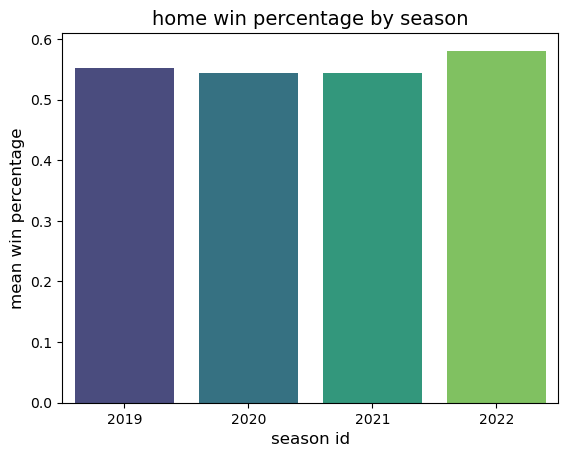

In [78]:
covid_wl_home = pd.read_sql_query("SELECT team_name_home, wl_home, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) ORDER BY season_id DESC", con)
covid_wl_home = covid_wl_home.replace('W', 1)
covid_wl_home = covid_wl_home.replace('L', 0)

covid_wl_home_group = covid_wl_home.groupby(['season_id']).agg({'wl_home': ['mean']})
covid_wl_home_group.columns = ['mean_win_percentage']
covid_wl_home_group = covid_wl_home_group.reset_index()

ax = sns.barplot(data=covid_wl_home_group, x='season_id', y='mean_win_percentage', hue='season_id', palette='viridis', dodge=False)
ax.set_title('home win percentage by season', fontsize=14)
ax.set_xlabel('season id', fontsize=12)
ax.set_ylabel('mean win percentage', fontsize=12)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()


C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3264158331.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_wl_away = covid_wl_away.replace('L', 0)
C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3264158331.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)


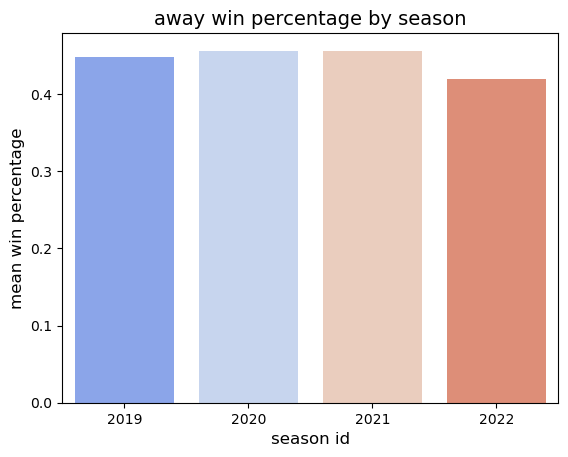

In [77]:
covid_wl_away = pd.read_sql_query("SELECT team_name_away, wl_away, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) ORDER BY season_id DESC", con)
covid_wl_away = covid_wl_away.replace('W', 1)
covid_wl_away = covid_wl_away.replace('L', 0)

covid_wl_away_group = covid_wl_away.groupby(['season_id']).agg({'wl_away': ['mean']})
covid_wl_away_group.columns = ['mean_win_percentage']
covid_wl_away_group = covid_wl_away_group.reset_index()

ax = sns.barplot(data=covid_wl_away_group, x='season_id', y='mean_win_percentage', hue='season_id', palette='coolwarm', dodge=False)
ax.set_title('away win percentage by season', fontsize=14)
ax.set_xlabel('season id', fontsize=12)
ax.set_ylabel('mean win percentage', fontsize=12)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\2956523681.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_wl_home = covid_wl_home.replace('L', 0)
C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\2956523681.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)


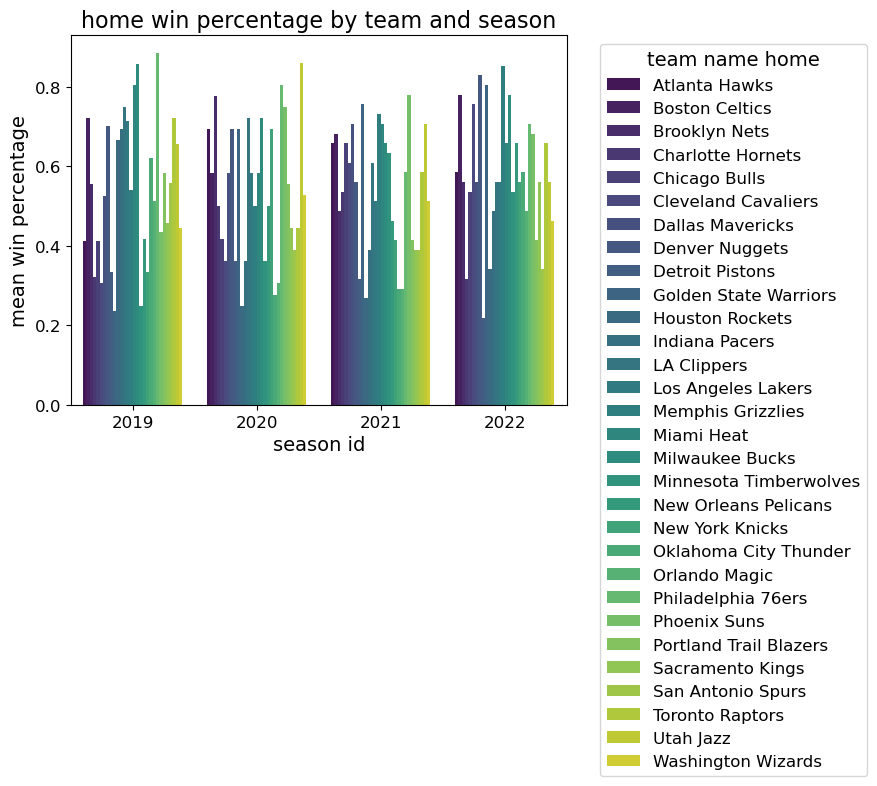

In [79]:
covid_wl_home = pd.read_sql_query("SELECT team_name_home, wl_home, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) ORDER BY season_id DESC", con)
covid_wl_home = covid_wl_home.replace('W', 1)
covid_wl_home = covid_wl_home.replace('L', 0)

covid_wl_home_group = covid_wl_home.groupby(['team_name_home', 'season_id']).agg({'wl_home': ['mean']})
covid_wl_home_group.columns = ['mean_win_percentage']
covid_wl_home_group = covid_wl_home_group.reset_index()

ax = sns.barplot(data=covid_wl_home_group, x='season_id', y='mean_win_percentage', hue='team_name_home', palette='viridis')
ax.set_title('home win percentage by team and season', fontsize=16)
ax.set_xlabel('season id', fontsize=14)
ax.set_ylabel('mean win percentage', fontsize=14)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.legend(title='team name home', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3774071576.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  covid_wl_away = covid_wl_away.replace('L', 0)
C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3774071576.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)


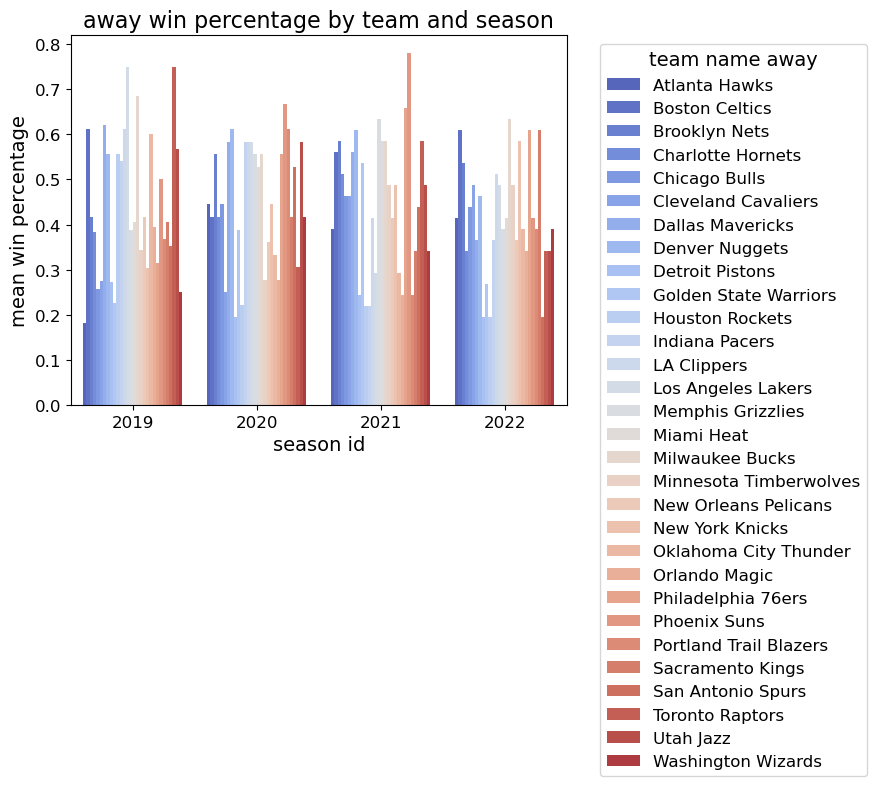

In [80]:
covid_wl_away = pd.read_sql_query("SELECT team_name_away, wl_away, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) ORDER BY season_id DESC", con)
covid_wl_away = covid_wl_away.replace('W', 1)
covid_wl_away = covid_wl_away.replace('L', 0)

covid_wl_away_group = covid_wl_away.groupby(['team_name_away', 'season_id']).agg({'wl_away': ['mean']})
covid_wl_away_group.columns = ['mean_win_percentage']
covid_wl_away_group = covid_wl_away_group.reset_index()

ax = sns.barplot(data=covid_wl_away_group, x='season_id', y='mean_win_percentage', hue='team_name_away', palette='coolwarm')
ax.set_title('away win percentage by team and season', fontsize=16)
ax.set_xlabel('season id', fontsize=14)
ax.set_ylabel('mean win percentage', fontsize=14)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.legend(title='team name away', fontsize=12, title_fontsize=14, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Question 2

Intro: During the 2020-21 and 2021-22 NBA seasons, the league put COVID-19 restrictions in place to protect players and fans from infection while still allowing for some games to be played. These restrictions included playing the second half of the 2020-21 season in a bubble and playing the entirity of the 2021-22 season behind closed doors without fans. The league requested that our team conduct an analysis to determine the impact of those restrictions on the level of home court advantage, including whether any impact recovered following the lifting of those restrictions.

Rising Action: The second statistic we reviewed was the difference in average points scored by the home and away teams in each season. In the 2019-20 season, home teams scored an average of 2.04 points more than away teams, with half of all home scores falling between 100 points and 120 points. While this does indicate a consistent home team advantage on average, it was not a significant advantage.

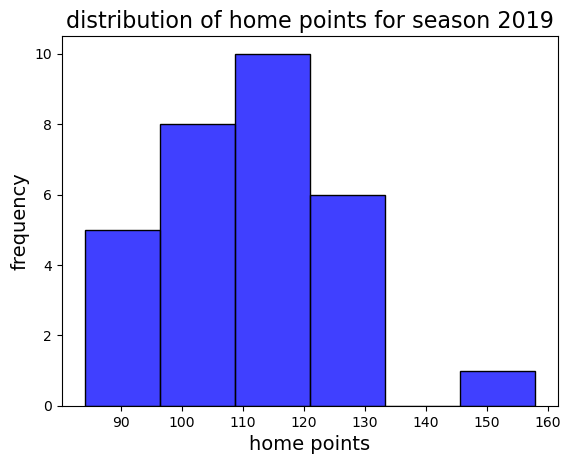

In [81]:
covid_pts_home_19 = pd.read_sql_query("SELECT team_name_home, pts_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)

sns.histplot(covid_pts_home_19['pts_home'], color='blue')

plt.title('distribution of home points for season 2019', fontsize=16)
plt.xlabel('home points', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

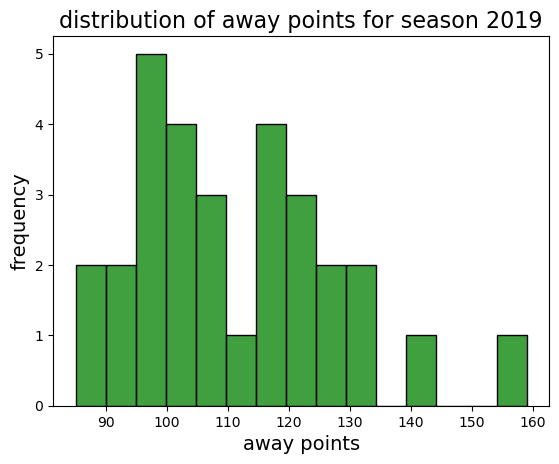

In [82]:
covid_pts_away_19 = pd.read_sql_query("SELECT team_name_away, pts_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
sns.histplot(covid_pts_away_19['pts_away'], color='green', bins=15)
plt.title('distribution of away points for season 2019', fontsize=16)
plt.xlabel('away points', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

Climax: This advantage continued into the 2020-21 and 2021-22 seasons, although it was reduced in the former season from 2.04 points to 1.09 points. However, the advantage mostly recovered in the 2021-22 season, increasing to 1.96 points. This may be due to teams performing better once they exited the bubble and returned to their home arenas, however additional analysis is required to confirm.

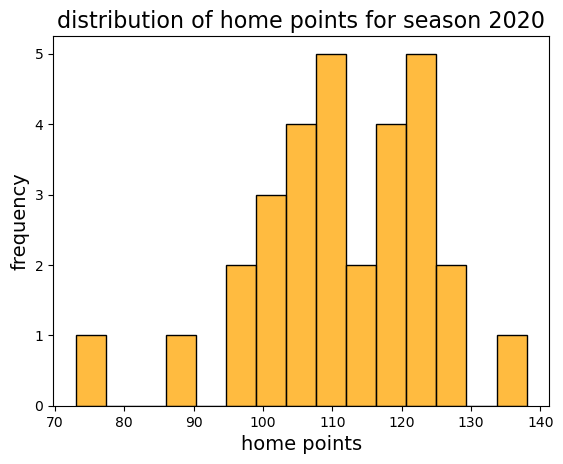

In [83]:
covid_pts_home_21 = pd.read_sql_query("SELECT team_name_home, pts_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
sns.histplot(covid_pts_home_21['pts_home'], color='orange', bins=15)
plt.title('distribution of home points for season 2020', fontsize=16)
plt.xlabel('home points', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

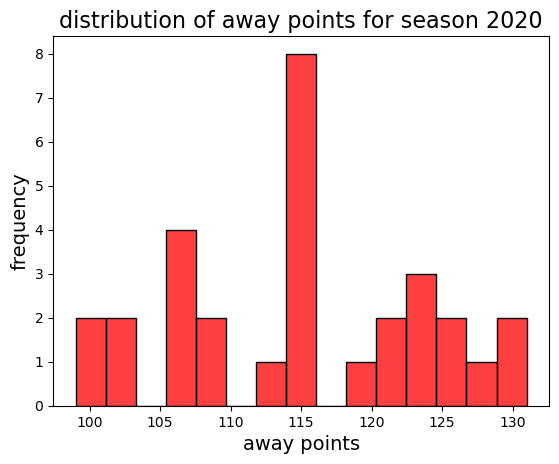

In [84]:
covid_pts_away_21 = pd.read_sql_query("SELECT team_name_away, pts_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)

sns.histplot(covid_pts_away_21['pts_away'], color='red', bins=15)
plt.title('distribution of away points for season 2020', fontsize=16)
plt.xlabel('away points', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

Falling Action: As fans returned in the 2022-23 season, the average home team points advantage continued to increase and reached 2.61 points. This increase may be due to the return of home fans leading to an increase in home court advantage, however additional analysis will be required to determine the significance of this increase.

Conclusion: The COVID restrictions during the 2020-21 and 2021-22 seasons may have had a significant impact on the level of home court advantage as measured by the difference between home and away points. However, that element of home court advantage appears to have recovered in the 2022-23 season.

In [17]:
result = []
for year in seasons:
    points_query = f"""
    SELECT 
        AVG(pts_home) AS avg_pts_home,
        AVG(pts_away) AS avg_pts_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    points_data = pd.read_sql_query(points_query, con)
    
    if not points_data.empty:
        avg_pts_home = points_data['avg_pts_home'][0]
        avg_pts_away = points_data['avg_pts_away'][0]
        
        points_diff = avg_pts_home - avg_pts_away
        
        result.append({
            'season_year': year,
            'avg_pts_home': avg_pts_home,
            'avg_pts_away': avg_pts_away,
            'points_diff': points_diff
        })

result_df = pd.DataFrame(result)
print(result_df)

  season_year  avg_pts_home  avg_pts_away  points_diff
0        2019    112.696413    110.651794     2.044619
1        2020    112.466283    111.369243     1.097039
2        2021    111.232659    109.271676     1.960983
3        2022    115.539683    112.931457     2.608225


In [18]:
covid_pts_home_19 = pd.read_sql_query("SELECT team_name_home, pts_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
covid_pts_home_19['pts_home'].describe()

count     30.000000
mean     111.066667
std       14.971083
min       84.000000
25%      100.500000
50%      110.500000
75%      120.000000
max      158.000000
Name: pts_home, dtype: float64

In [19]:
covid_pts_home_21 = pd.read_sql_query("SELECT team_name_home, pts_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
covid_pts_home_21['pts_home'].describe()

count     30.000000
mean     111.066667
std       12.940003
min       73.000000
25%      104.500000
50%      111.000000
75%      120.750000
max      138.000000
Name: pts_home, dtype: float64

In [20]:
covid_pts_away_19 = pd.read_sql_query("SELECT team_name_away, pts_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_pts_away_19['pts_away'].describe()

count     30.00000
mean     111.00000
std       17.15246
min       85.00000
25%       99.00000
50%      107.50000
75%      122.00000
max      159.00000
Name: pts_away, dtype: float64

In [21]:
covid_pts_away_21 = pd.read_sql_query("SELECT team_name_away, pts_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_pts_away_21['pts_away'].describe()

count     30.000000
mean     115.266667
std        8.893753
min       99.000000
25%      107.500000
50%      115.000000
75%      122.500000
max      131.000000
Name: pts_away, dtype: float64

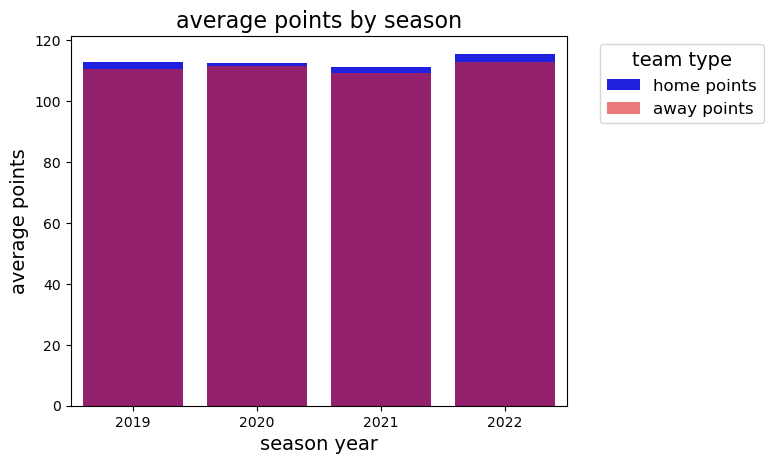

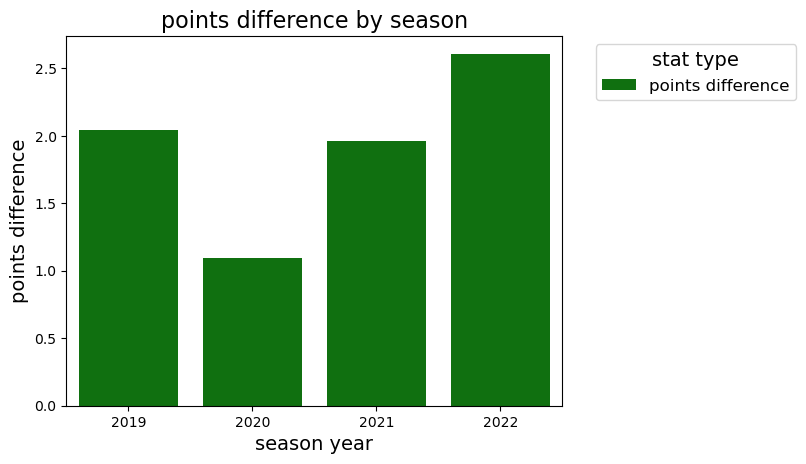

In [22]:
result = []
for year in seasons:
    points_query = f"""
    SELECT 
        AVG(pts_home) AS avg_pts_home,
        AVG(pts_away) AS avg_pts_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    points_data = pd.read_sql_query(points_query, con)
    
    if not points_data.empty:
        avg_pts_home = points_data['avg_pts_home'][0]
        avg_pts_away = points_data['avg_pts_away'][0]
        
        points_diff = avg_pts_home - avg_pts_away
        
        result.append({
            'season_year': year,
            'avg_pts_home': avg_pts_home,
            'avg_pts_away': avg_pts_away,
            'points_diff': points_diff
        })

result_df = pd.DataFrame(result)
sns.barplot(data=result_df, x='season_year', y='avg_pts_home', color='blue', label='home points')
sns.barplot(data=result_df, x='season_year', y='avg_pts_away', color='red', alpha=0.6, label='away points')
plt.title('average points by season', fontsize=16)
plt.xlabel('season year', fontsize=14)
plt.ylabel('average points', fontsize=14)
plt.legend(title='team type', fontsize=12, bbox_to_anchor=(1.05, 1), title_fontsize=14)
plt.show()

sns.barplot(data=result_df, x='season_year', y='points_diff', color='green', label='points difference')
plt.title('points difference by season', fontsize=16)
plt.xlabel('season year', fontsize=14)
plt.ylabel('points difference', fontsize=14)
plt.legend(title='stat type', fontsize=12, bbox_to_anchor=(1.05, 1), title_fontsize=14)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\1731091044.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=14)


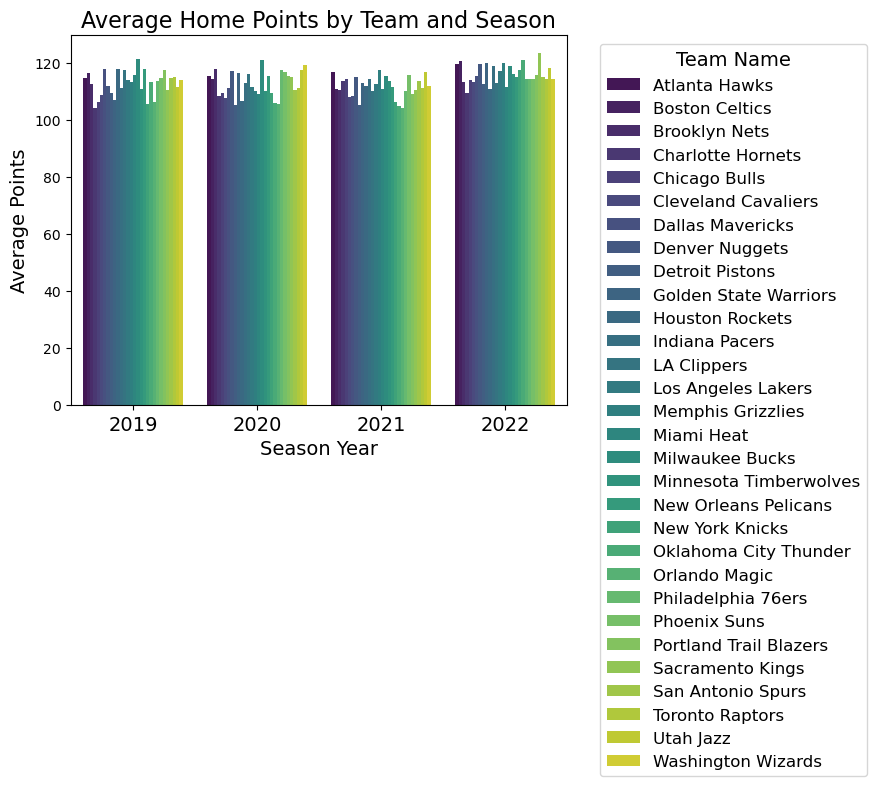

In [97]:
covid_pts_home = pd.read_sql_query("SELECT team_name_home, AVG(pts_home), season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_home, season_id", con)
covid_pts_home.columns = ['team_name_home', 'avg_pts_home', 'season_id']

ax = sns.barplot(data=covid_pts_home, x='season_id', y='avg_pts_home', hue='team_name_home', palette='viridis')

ax.set_title('Average Home Points by Team and Season', fontsize=16)
ax.set_xlabel('Season Year', fontsize=14)
ax.set_ylabel('Average Points', fontsize=14)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=14)
plt.legend(title='Team Name', fontsize=12, bbox_to_anchor=(1.05, 1), title_fontsize=14)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\2583088591.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=14)


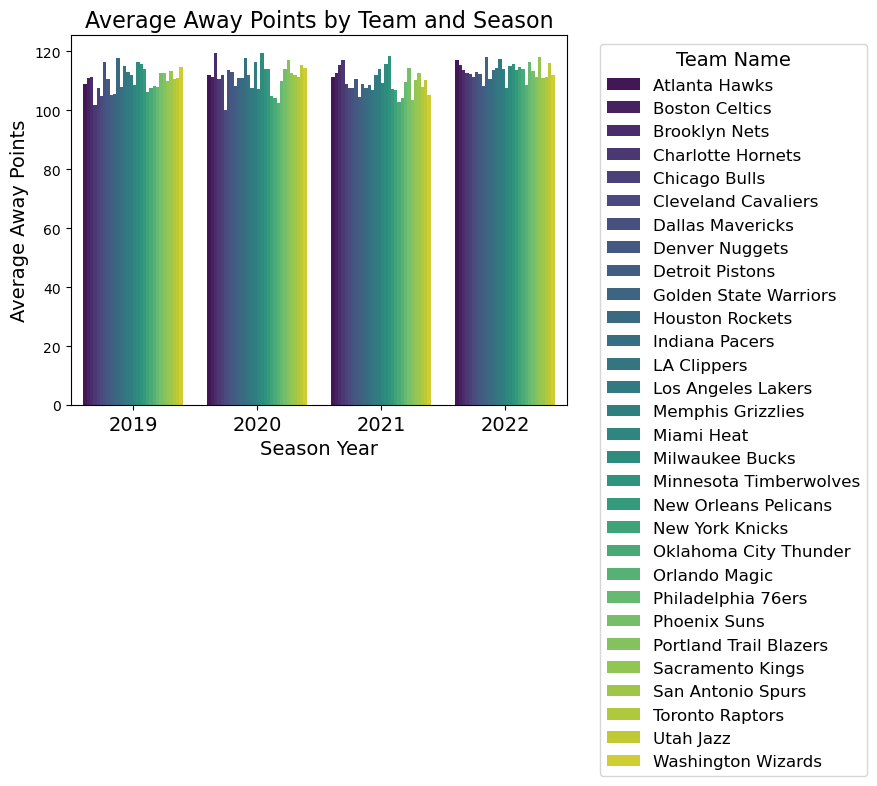

In [100]:
covid_pts_away = pd.read_sql_query("SELECT team_name_away, AVG(pts_away) AS avg_pts_away, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_away, season_id", con)
ax = sns.barplot(data=covid_pts_away, x='season_id', y='avg_pts_away', hue='team_name_away', palette='viridis')

ax.set_title('Average Away Points by Team and Season', fontsize=16)
ax.set_xlabel('Season Year', fontsize=14)
ax.set_ylabel('Average Away Points', fontsize=14)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=14)

plt.legend(title='Team Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.show()

Question 3

Intro: During the 2020-21 and 2021-22 NBA seasons, the league put COVID-19 restrictions in place to protect players and fans from infection while still allowing for some games to be played. These restrictions included playing the second half of the 2020-21 season in a bubble and playing the entirity of the 2021-22 season behind closed doors without fans. The league requested that our team conduct an analysis to determine the impact of those restrictions on the level of home court advantage, including whether any impact recovered following the lifting of those restrictions. 

Rising Action: The third statistic we reviewed was the difference in average offensive and defensive rebounds scored by the home and away teams in each season. In the 2019-20 season, home teams scored an average of 0.38 more offensive rebounds and 0.95 defensive rebounds compared to away teams. While this does indicate a slight advantage towards home teams, it is less than a single rebound on average.

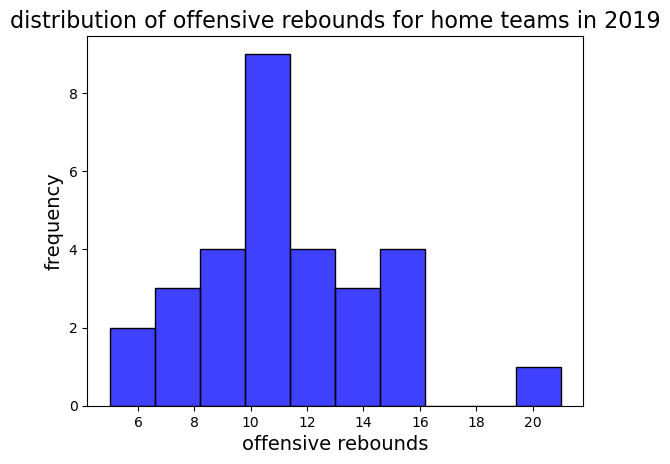

In [131]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
sns.histplot(covid_reb_home['oreb_home'], color='blue', bins=10)

plt.title('distribution of offensive rebounds for home teams in 2019', fontsize=16)
plt.xlabel('offensive rebounds', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

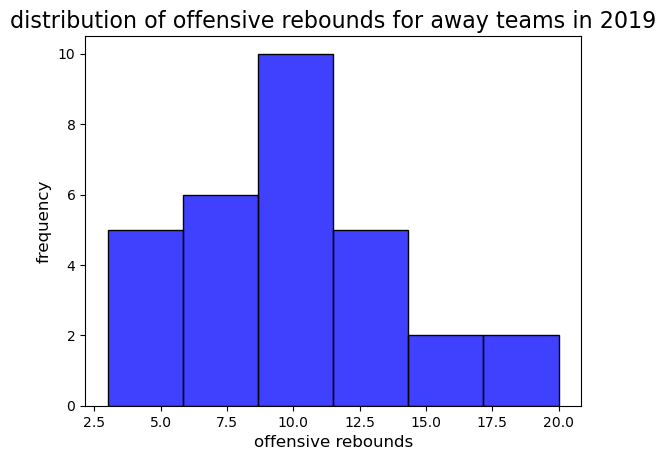

In [130]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_reb_away['oreb_away'].describe()

sns.histplot(covid_reb_away['oreb_away'],color='blue')
plt.xlabel('offensive rebounds', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('distribution of offensive rebounds for away teams in 2019', fontsize=16)
plt.show()

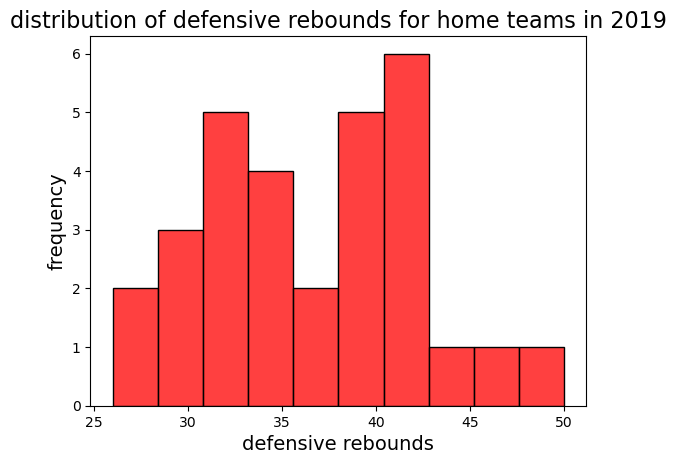

In [124]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
sns.histplot(covid_reb_home['dreb_home'], color='red', bins=10)

plt.title('distribution of defensive rebounds for home teams in 2019', fontsize=16)
plt.xlabel('defensive rebounds', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

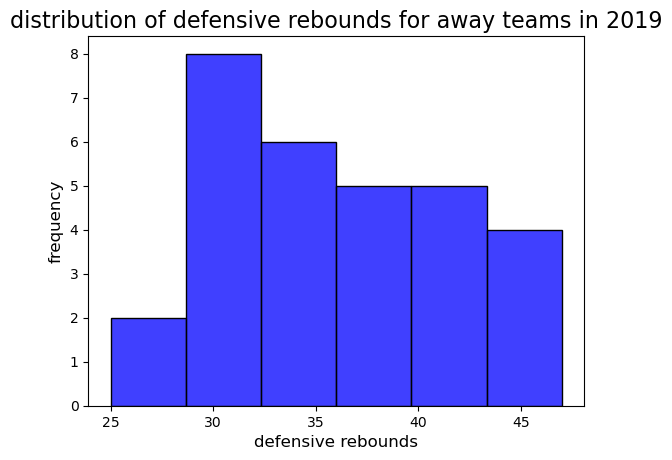

In [125]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_reb_away['dreb_away'].describe()

sns.histplot(covid_reb_away['dreb_away'],color='blue')
plt.xlabel('defensive rebounds', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('distribution of defensive rebounds for away teams in 2019', fontsize=16)
plt.show()

Climax: This slight difference between home and away teams became even more slight following the introduction of COVID restrictions. Home teams scored only 0.15 more offensive rebounds on average in the 2020-21 season, with the difference reducing further to 0.07 rebounds in the 2021-22 season. On the defensive rebound side, the difference was cut almost in half by the 2021-22 season, with home teams scoring 0.54 more rebounds that away teams in that season. This could be an indication of a reduction of the level of home court advantage, although additional analysis is required to confirm this finding.

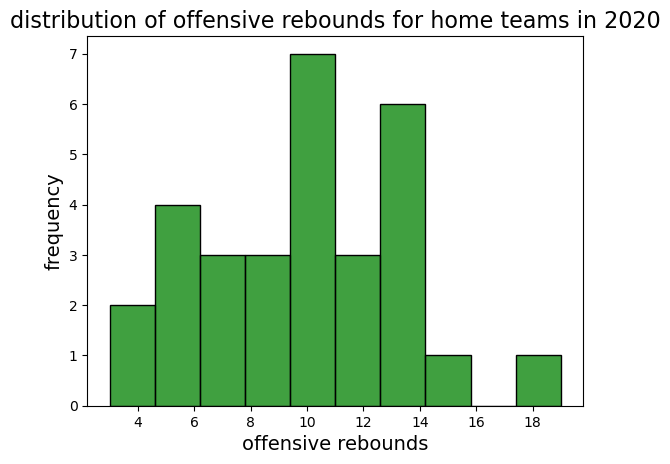

In [126]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)

sns.histplot(covid_reb_home['oreb_home'], color='green', bins=10)

plt.title('distribution of offensive rebounds for home teams in 2020', fontsize=16)
plt.xlabel('offensive rebounds', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

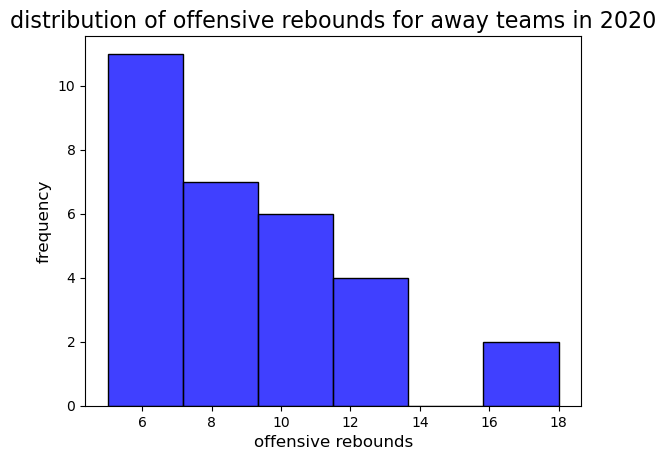

In [127]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_reb_away['oreb_away'].describe()

sns.histplot(covid_reb_away['oreb_away'],color='blue')
plt.xlabel('offensive rebounds', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('distribution of offensive rebounds for away teams in 2020', fontsize=16)
plt.show()

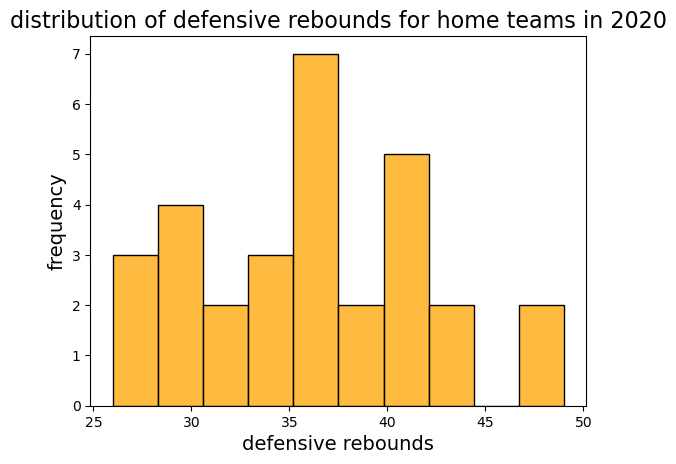

In [128]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
sns.histplot(covid_reb_home['dreb_home'], color='orange', bins=10)

plt.title('distribution of defensive rebounds for home teams in 2020', fontsize=16)
plt.xlabel('defensive rebounds', fontsize=14)
plt.ylabel('frequency', fontsize=14)
plt.show()

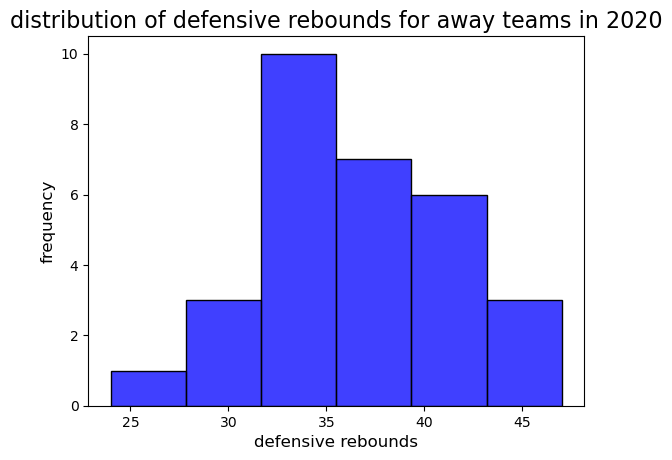

In [129]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_reb_away['dreb_away'].describe()

sns.histplot(covid_reb_away['dreb_away'],color='blue')
plt.xlabel('defensive rebounds', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('distribution of defensive rebounds for away teams in 2020', fontsize=16)
plt.show()

Falling Action: While the differences in average offensive and defensive rebounds both decreased following the introduction of COVID restrictions, the lifting of those restrictions did not result in a uniform increase. The average difference between home and away offensive rebounds actually continued to decrease, reaching 0.066 rebounds in the 2022-23 season. On the other hand, the average difference in defense rebounds rebounded to just under its original mark with an average difference of 0.94 rebounds in the 2022-23 season. Additional analysis is required to determine the relationship between these changes and the level of home court advantage.

Conclusion: The COVID restrictions during the 2020-21 and 2021-22 seasons may have had an impact on home court advantage as measured by the difference in average offensive and defensive rebounds between home and away teams. However, additional analysis is required to fully determine the significance of this impact.

In [33]:
result = []
for year in seasons:
    rebounds_query = f"""
    SELECT 
        AVG(oreb_home) AS avg_oreb_home,
        AVG(oreb_away) AS avg_oreb_away,
        AVG(dreb_home) AS avg_dreb_home,
        AVG(dreb_away) AS avg_dreb_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    rebounds_data = pd.read_sql_query(rebounds_query, con)
    
    if not rebounds_data.empty:
        avg_oreb_home = rebounds_data['avg_oreb_home'][0]
        avg_oreb_away = rebounds_data['avg_oreb_away'][0]
        avg_dreb_home = rebounds_data['avg_dreb_home'][0]
        avg_dreb_away = rebounds_data['avg_dreb_away'][0]
        
        oreb_diff = avg_oreb_home - avg_oreb_away
        dreb_diff = avg_dreb_home - avg_dreb_away
        
        result.append({
            'season_year': year,
            'avg_oreb_home': avg_oreb_home,
            'avg_oreb_away': avg_oreb_away,
            'oreb_diff': oreb_diff,
            'avg_dreb_home': avg_dreb_home,
            'avg_dreb_away': avg_dreb_away,
            'dreb_diff': dreb_diff
        })

result_df = pd.DataFrame(result)
print(result_df)

  season_year  avg_oreb_home  avg_oreb_away  oreb_diff  avg_dreb_home  \
0        2019      10.179353       9.794401   0.384952      35.209974   
1        2020       9.896382       9.742599   0.153783      34.866776   
2        2021      10.309249      10.236994   0.072254      34.416185   
3        2022      10.485570      10.419913   0.065657      33.575758   

   avg_dreb_away  dreb_diff  
0      34.256343   0.953631  
1      34.178454   0.688322  
2      33.875000   0.541185  
3      32.632756   0.943001  


In [34]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
covid_reb_home['oreb_home'].describe()

count    30.000000
mean     11.133333
std       3.401149
min       5.000000
25%       9.000000
50%      11.000000
75%      12.750000
max      21.000000
Name: oreb_home, dtype: float64

In [35]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
covid_reb_home['oreb_home'].describe()

count    30.000000
mean      9.700000
std       3.602202
min       3.000000
25%       7.000000
50%      10.000000
75%      12.750000
max      19.000000
Name: oreb_home, dtype: float64

In [36]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
covid_reb_home['dreb_home'].describe()

count    30.000000
mean     36.533333
std       5.763939
min      26.000000
25%      32.000000
50%      36.500000
75%      41.000000
max      50.000000
Name: dreb_home, dtype: float64

In [37]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, oreb_home, dreb_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
covid_reb_home['dreb_home'].describe()

count    30.000000
mean     36.166667
std       5.866817
min      26.000000
25%      31.000000
50%      36.500000
75%      40.000000
max      49.000000
Name: dreb_home, dtype: float64

In [38]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_reb_away['oreb_away'].describe()

count    30.000000
mean      9.833333
std       4.291799
min       3.000000
25%       6.250000
50%      10.000000
75%      12.000000
max      20.000000
Name: oreb_away, dtype: float64

In [39]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_reb_away['oreb_away'].describe()

count    30.000000
mean      9.133333
std       3.115405
min       5.000000
25%       7.000000
50%       8.500000
75%      11.000000
max      18.000000
Name: oreb_away, dtype: float64

In [40]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_reb_away['dreb_away'].describe()

count    30.000000
mean     35.766667
std       5.624352
min      25.000000
25%      32.000000
50%      35.000000
75%      40.000000
max      47.000000
Name: dreb_away, dtype: float64

In [41]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, oreb_away, dreb_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_reb_away['dreb_away'].describe()

count    30.000000
mean     36.166667
std       5.180090
min      24.000000
25%      33.250000
50%      36.000000
75%      40.000000
max      47.000000
Name: dreb_away, dtype: float64

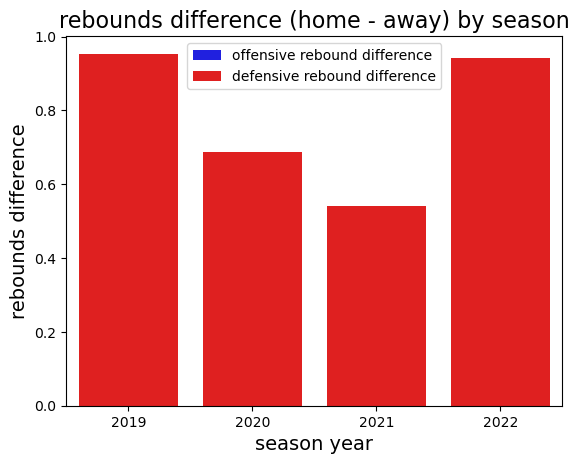

In [42]:
result = []
for year in seasons:
    rebounds_query = f"""
    SELECT 
        AVG(oreb_home) AS avg_oreb_home,
        AVG(oreb_away) AS avg_oreb_away,
        AVG(dreb_home) AS avg_dreb_home,
        AVG(dreb_away) AS avg_dreb_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    rebounds_data = pd.read_sql_query(rebounds_query, con)
    
    if not rebounds_data.empty:
        avg_oreb_home = rebounds_data['avg_oreb_home'][0]
        avg_oreb_away = rebounds_data['avg_oreb_away'][0]
        avg_dreb_home = rebounds_data['avg_dreb_home'][0]
        avg_dreb_away = rebounds_data['avg_dreb_away'][0]
        
        oreb_diff = avg_oreb_home - avg_oreb_away
        dreb_diff = avg_dreb_home - avg_dreb_away
        
        result.append({
            'season_year': year,
            'avg_oreb_home': avg_oreb_home,
            'avg_oreb_away': avg_oreb_away,
            'oreb_diff': oreb_diff,
            'avg_dreb_home': avg_dreb_home,
            'avg_dreb_away': avg_dreb_away,
            'dreb_diff': dreb_diff
        })

result_df = pd.DataFrame(result)
sns.barplot(data=result_df, x='season_year', y='oreb_diff', color='blue', label='offensive rebound difference')
sns.barplot(data=result_df, x='season_year', y='dreb_diff', color='red', label='defensive rebound difference')

plt.title('rebounds difference (home - away) by season', fontsize=16)
plt.xlabel('season year', fontsize=14)
plt.ylabel('rebounds difference', fontsize=14)
plt.legend()
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3071516684.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=12)


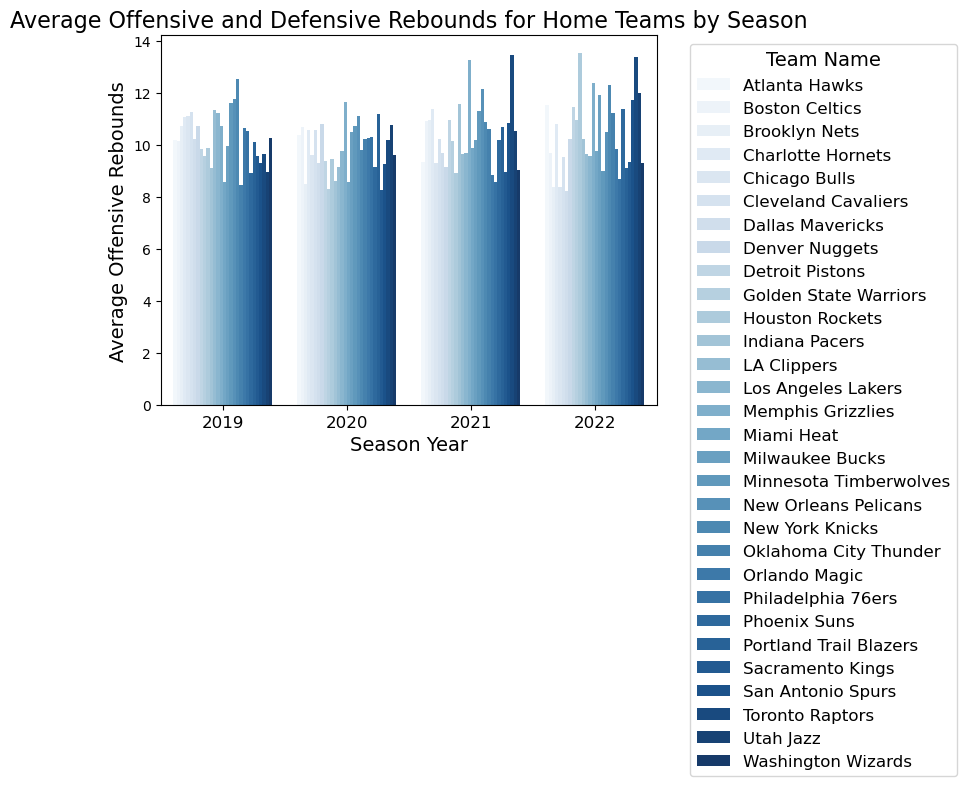

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3071516684.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=12)


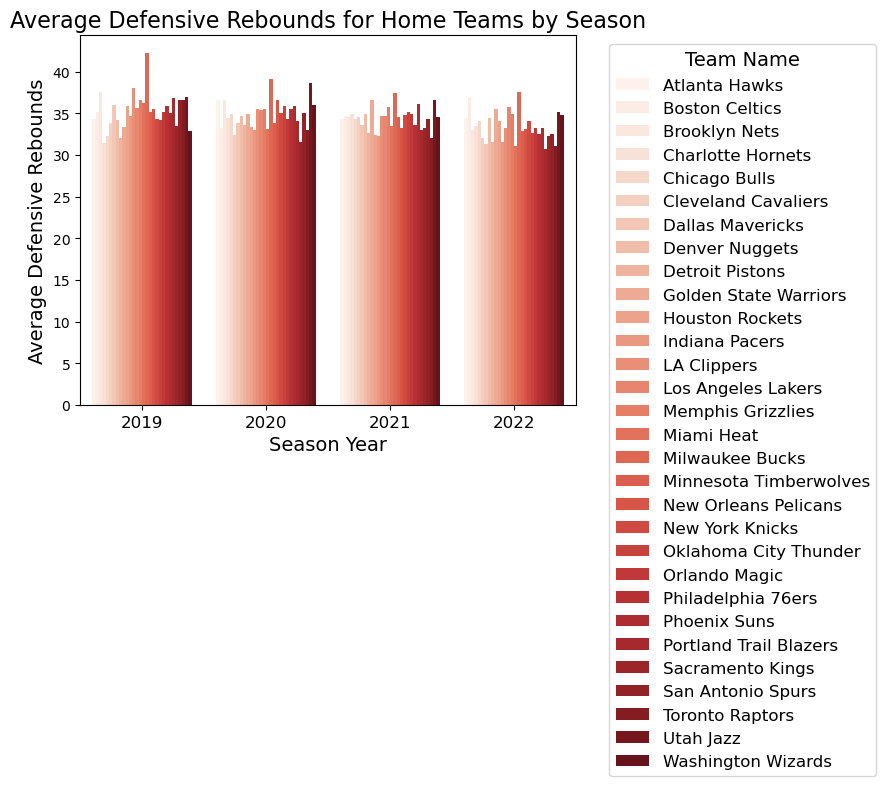

In [102]:
covid_reb_home = pd.read_sql_query("SELECT team_name_home, AVG(oreb_home) AS avg_oreb_home, AVG(dreb_home) AS avg_dreb_home, season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_home, season_id", con)
ax1 = sns.barplot(data=covid_reb_home, x='season_id', y='avg_oreb_home', hue='team_name_home', palette='Blues')
ax1.set_title('Average Offensive and Defensive Rebounds for Home Teams by Season', fontsize=16)
ax1.set_xlabel('Season Year', fontsize=14)
ax1.set_ylabel('Average Offensive Rebounds', fontsize=14)
ax1.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=12)
plt.legend(title='Team Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.show()

ax2 = sns.barplot(data=covid_reb_home, x='season_id', y='avg_dreb_home', hue='team_name_home', palette='Reds')
ax2.set_title('Average Defensive Rebounds for Home Teams by Season', fontsize=16)
ax2.set_xlabel('Season Year', fontsize=14)
ax2.set_ylabel('Average Defensive Rebounds', fontsize=14)
ax2.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=12)
plt.legend(title='Team Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12, title_fontsize=14)
plt.show()


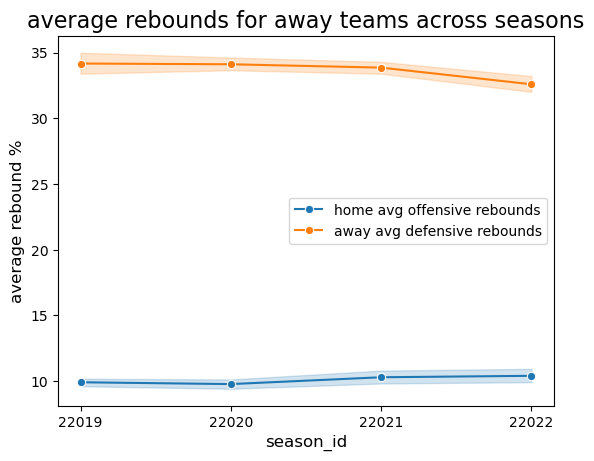

In [112]:
covid_reb_away = pd.read_sql_query("SELECT team_name_away, AVG(oreb_away), AVG(dreb_away), season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_away, season_id", con)
sns.lineplot(data=covid_reb_away, x='season_id', y='AVG(oreb_away)', label='home avg offensive rebounds', marker='o')
sns.lineplot(data=covid_reb_away, x='season_id', y='AVG(dreb_away)', label='away avg defensive rebounds', marker='o')
plt.xlabel('season_id', fontsize=12)
plt.ylabel('average rebound %', fontsize=12)
plt.title('average rebounds for away teams across seasons', fontsize=16)
plt.legend()
plt.show()

Question 4

Intro: During the 2020-21 and 2021-22 NBA seasons, the league put COVID-19 restrictions in place to protect players and fans from infection while still allowing for some games to be played. These restrictions included playing the second half of the 2020-21 season in a bubble and playing the entirity of the 2021-22 season behind closed doors without fans. The league requested that our team conduct an analysis to determine the impact of those restrictions on the level of home court advantage, including whether any impact recovered following the lifting of those restrictions. 

Rising action: The fourth statistic we reviewed was the difference in the average succcessful three-point field goal percentage by home and away teams. In the 2019-20 season, home teams successfully scored slightly more field goals on average compared to away teams (36.1% vs 35.4%), however that difference is less than a percentage point and may not be statistically significant.

Climax: The difference continued to be relatively minor as COVID restrictions were instituted. While home teams continued to successfully score slightly more three-point field goals on average compared to away teams, they only scored 0.5 percentage points more in the 2020-21 and 2021-22 seasons. The raw percentage of field goals scored by both home and away teams did decrease slightly in the 2021-22 season, however that decrease may not be significant.

Falling action: As COVID restrictions lifted in the 2022-23 season, the average successful three-point field goal percentage returned to rougly the values observed in the 2019-20 season, with the home average slightly above and the away percentage slightly below. Overall, the shift in the two percentages over the four seasons in our sample was less than two percentage points.

Conclusion: The COVID restrictions during the 2020-21 and 2021-22 seasons did not appear to have had a significant impact on home court advantage as measured by the difference in the successful three-point field goal percentage between home and away teams.

In [45]:
result = []
for year in seasons:
    fg3_query = f"""
    SELECT 
        AVG(fg3_pct_home) AS avg_fg3_pct_home,
        AVG(fg3_pct_away) AS avg_fg3_pct_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    fg3_data = pd.read_sql_query(fg3_query, con)
    
    if not fg3_data.empty:
        avg_fg3_pct_home = fg3_data['avg_fg3_pct_home'][0]
        avg_fg3_pct_away = fg3_data['avg_fg3_pct_away'][0]
        
        result.append({
            'season_year': year,
            'avg_fg3_pct_home': avg_fg3_pct_home,
            'avg_fg3_pct_away': avg_fg3_pct_away
        })

result_df = pd.DataFrame(result)
print(result_df)

  season_year  avg_fg3_pct_home  avg_fg3_pct_away
0        2019          0.361411          0.353990
1        2020          0.367235          0.362348
2        2021          0.354915          0.350280
3        2022          0.362962          0.351737


In [46]:
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, fg3_pct_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
covid_fg3_home['fg3_pct_home'].describe()

count    30.000000
mean      0.332833
std       0.077337
min       0.217000
25%       0.274750
50%       0.333000
75%       0.356500
max       0.556000
Name: fg3_pct_home, dtype: float64

In [47]:
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, fg3_pct_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
covid_fg3_home['fg3_pct_home'].describe()

count    30.00000
mean      0.33530
std       0.09684
min       0.12100
25%       0.27600
50%       0.35350
75%       0.40325
max       0.55600
Name: fg3_pct_home, dtype: float64

In [48]:
covid_fg3_away = pd.read_sql_query("SELECT team_name_away, fg3_pct_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_fg3_away['fg3_pct_away'].describe()

count    30.000000
mean      0.344267
std       0.099422
min       0.152000
25%       0.289500
50%       0.346500
75%       0.379000
max       0.563000
Name: fg3_pct_away, dtype: float64

In [49]:
covid_fg3_away = pd.read_sql_query("SELECT team_name_away, fg3_pct_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_fg3_away['fg3_pct_away'].describe()

count    30.000000
mean      0.373267
std       0.074224
min       0.229000
25%       0.345250
50%       0.365000
75%       0.412750
max       0.538000
Name: fg3_pct_away, dtype: float64

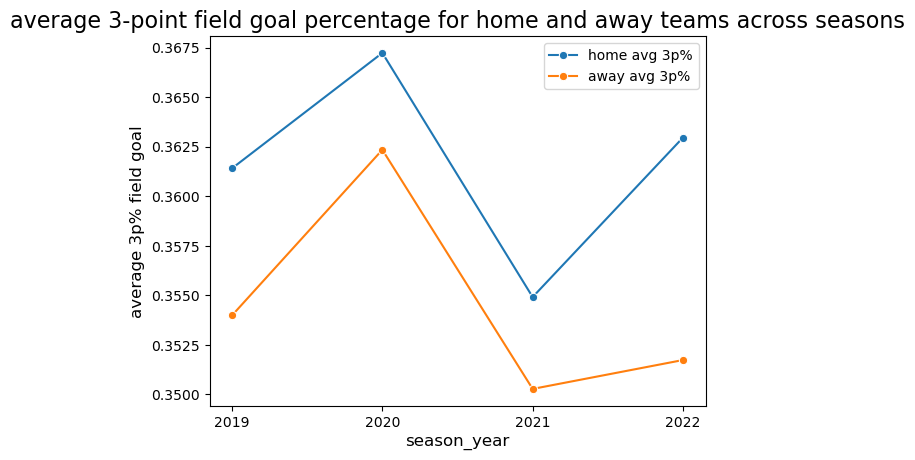

In [50]:
result = []
for year in seasons:
    fg3_query = f"""
    SELECT 
        AVG(fg3_pct_home) AS avg_fg3_pct_home,
        AVG(fg3_pct_away) AS avg_fg3_pct_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    fg3_data = pd.read_sql_query(fg3_query, con)
    
    if not fg3_data.empty:
        avg_fg3_pct_home = fg3_data['avg_fg3_pct_home'][0]
        avg_fg3_pct_away = fg3_data['avg_fg3_pct_away'][0]
        
        result.append({
            'season_year': year,
            'avg_fg3_pct_home': avg_fg3_pct_home,
            'avg_fg3_pct_away': avg_fg3_pct_away
        })

result_df = pd.DataFrame(result)
sns.lineplot(data=result_df, x='season_year', y='avg_fg3_pct_home', label='home avg 3p%', marker='o')
sns.lineplot(data=result_df, x='season_year', y='avg_fg3_pct_away', label='away avg 3p%', marker='o')
plt.xlabel('season_year', fontsize=12)
plt.ylabel('average 3p% field goal', fontsize=12)
plt.title('average 3-point field goal percentage for home and away teams across seasons', fontsize=16)
plt.legend()
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3738842231.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], rotation=45, fontsize=10)


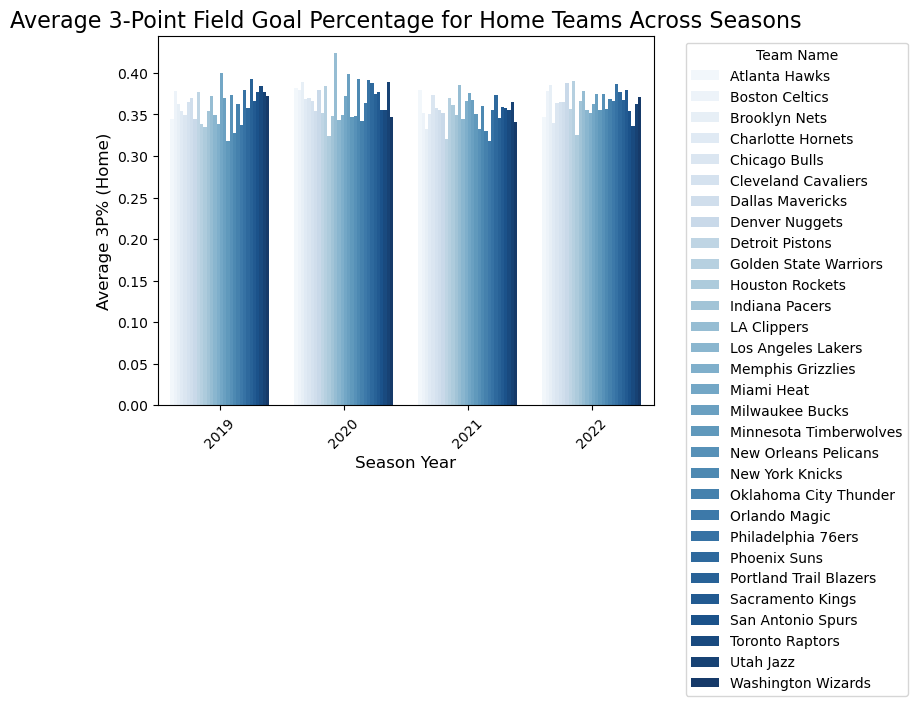

In [113]:
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, AVG(fg3_pct_home), season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_home, season_id", con)
ax = sns.barplot(data=covid_fg3_home, x='season_id', y='AVG(fg3_pct_home)', hue='team_name_home', palette='Blues')
ax.set_xlabel('Season Year', fontsize=12)
ax.set_ylabel('Average 3P% (Home)', fontsize=12)
ax.set_title('Average 3-Point Field Goal Percentage for Home Teams Across Seasons', fontsize=16)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], rotation=45, fontsize=10)


plt.legend(title='Team Name', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\1907949152.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=covid_fg3_home, x='team_name_home', y='fg3_pct_home', palette='Blues')


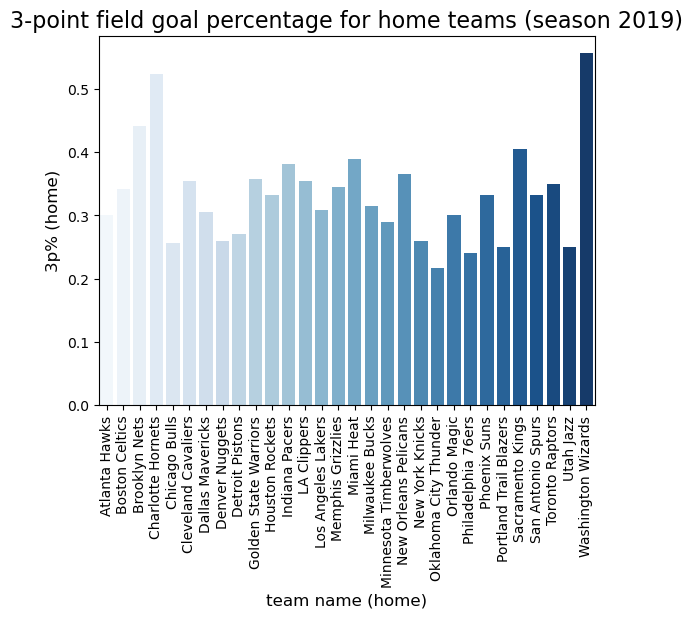

In [114]:
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, fg3_pct_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, fg3_pct_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
sns.barplot(data=covid_fg3_home, x='team_name_home', y='fg3_pct_home', palette='Blues')
plt.xlabel('team name (home)', fontsize=12)
plt.ylabel('3p% (home)', fontsize=12)
plt.title('3-point field goal percentage for home teams (season 2019)', fontsize=16)
plt.xticks(rotation=90)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3515934571.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=covid_fg3_home, x='team_name_home', y='fg3_pct_home', palette='Blues')


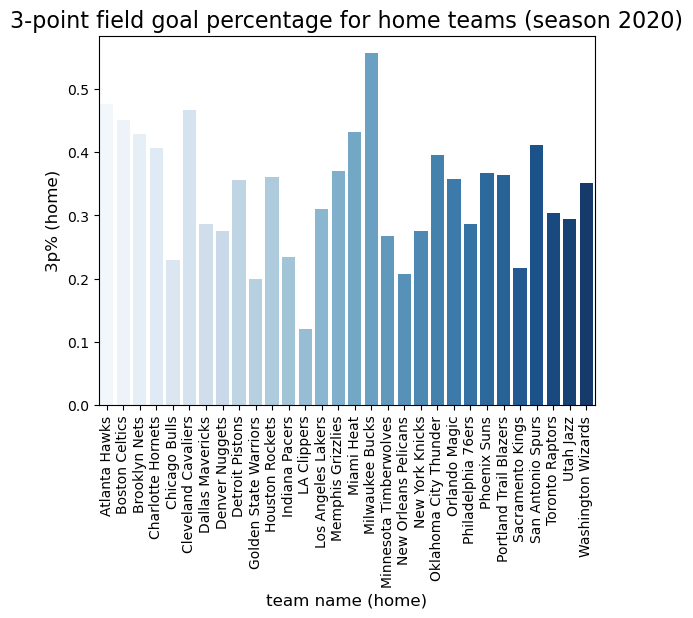

In [115]:
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, fg3_pct_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
covid_fg3_home = pd.read_sql_query("SELECT team_name_home, fg3_pct_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)

sns.barplot(data=covid_fg3_home, x='team_name_home', y='fg3_pct_home', palette='Blues')
plt.xlabel('team name (home)', fontsize=12)
plt.ylabel('3p% (home)', fontsize=12)
plt.title('3-point field goal percentage for home teams (season 2020)', fontsize=16)
plt.xticks(rotation=90)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\1258197974.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], rotation=45, fontsize=10)


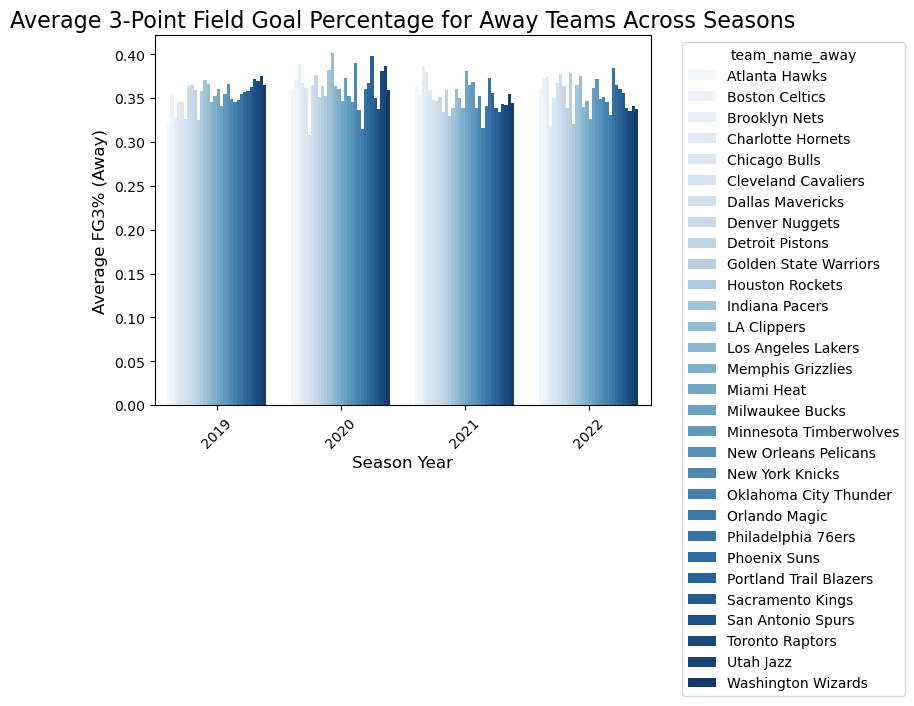

In [116]:
covid_fg3_away = pd.read_sql_query("SELECT team_name_away, AVG(fg3_pct_away), season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_away, season_id", con)
ax = sns.barplot(data=covid_fg3_away, x='season_id', y='AVG(fg3_pct_away)', hue='team_name_away', palette='Blues')

ax.set_xlabel('Season Year', fontsize=12)
ax.set_ylabel('Average FG3% (Away)', fontsize=12)
ax.set_title('Average 3-Point Field Goal Percentage for Away Teams Across Seasons', fontsize=16)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], rotation=45, fontsize=10)

plt.legend(title='team_name_away', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

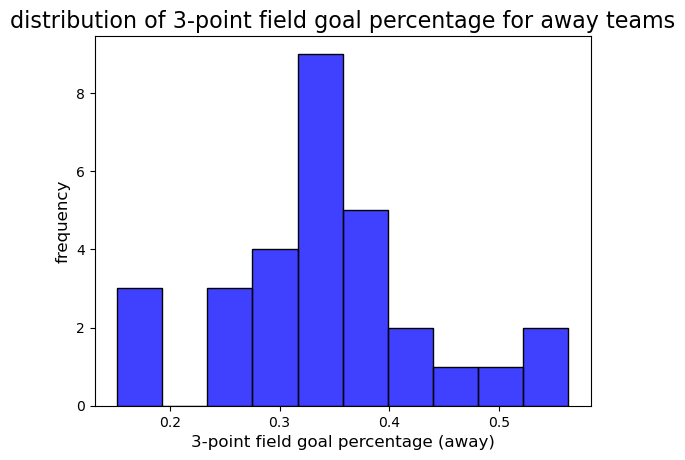

In [55]:
covid_fg3_away = pd.read_sql_query("SELECT team_name_away, fg3_pct_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
sns.histplot(covid_fg3_away['fg3_pct_away'], color='blue', bins=10)
plt.xlabel('3-point field goal percentage (away)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('distribution of 3-point field goal percentage for away teams', fontsize=16)
plt.show()

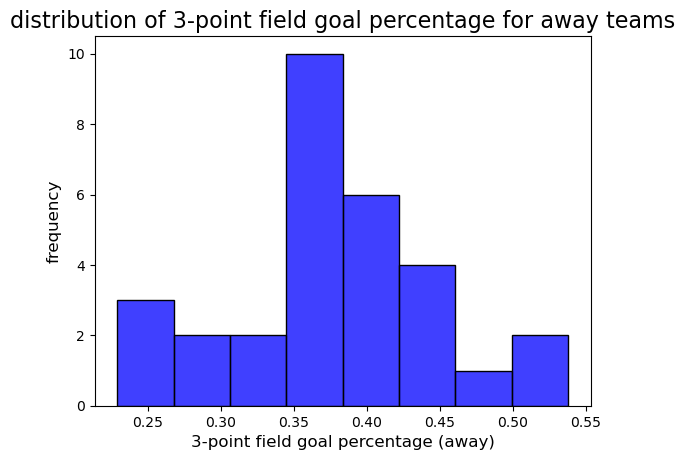

In [56]:
covid_fg3_away = pd.read_sql_query("SELECT team_name_away, fg3_pct_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
sns.histplot(covid_fg3_away['fg3_pct_away'],color='blue')

plt.xlabel('3-point field goal percentage (away)', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('distribution of 3-point field goal percentage for away teams', fontsize=16)
plt.show()

Question 5

Intro: During the 2020-21 and 2021-22 NBA seasons, the league put COVID-19 restrictions in place to protect players and fans from infection while still allowing for some games to be played. These restrictions included playing the second half of the 2020-21 season in a bubble and playing the entirity of the 2021-22 season behind closed doors without fans. The league requested that our team conduct an analysis to determine the impact of those restrictions on the level of home court advantage, including whether any impact recovered following the lifting of those restrictions. 

Rising Action: The final statistic we reviewed was the difference in the average succcessful field goal percentage by home and away teams. In the 2019-20 season, away teams actually made slightly more field goals on average compared to home teams (77.24% vs 77.18%). However, that difference is likely not statistically significant and does not appear to indicate any home court advantage.

Climax: The difference continued to be relatively minor as COVID restrictions were instituted. The successful field goal percentages for home and away teams remained within half a percentage point in both the 2020-21 and 2021-22 seasons, with home teams having a slightly higher percentage in the former season and away teams having a slightly higher percentage in the latter. None of these differences appear to be significant.

Falling Action: This pattern continued into the 2022-23 season. While both percentages rose slightly, they remained within half a percentage point of each other. Home teams also returned to having a slightly higher average percentage, albiet by 0.2 percentage points.

Conclusion: The COVID restrictions during the 2020-21 and 2021-22 seasons did not appear to have had a significant impact on home court advantage as measured by the difference in the successful field goal percentage between home and away teams.

In [57]:
result = []
for year in seasons:
    ft_query = f"""
    SELECT 
        AVG(ft_pct_home) AS avg_ft_pct_home,
        AVG(ft_pct_away) AS avg_ft_pct_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    ft_data = pd.read_sql_query(ft_query, con)
    
    if not ft_data.empty:
        avg_ft_pct_home = ft_data['avg_ft_pct_home'][0]
        avg_ft_pct_away = ft_data['avg_ft_pct_away'][0]
        
        result.append({
            'season_year': year,
            'avg_ft_pct_home': avg_ft_pct_home,
            'avg_ft_pct_away': avg_ft_pct_away
        })

result_df = pd.DataFrame(result)
print(result_df)



  season_year  avg_ft_pct_home  avg_ft_pct_away
0        2019         0.771852         0.772411
1        2020         0.779016         0.775290
2        2021         0.775135         0.775920
3        2022         0.782598         0.780615


In [58]:
covid_fg_home = pd.read_sql_query("SELECT team_name_home, fg_pct_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
covid_fg_home['fg_pct_home'].describe()

count    30.000000
mean      0.441867
std       0.061571
min       0.299000
25%       0.400500
50%       0.432500
75%       0.474000
max       0.626000
Name: fg_pct_home, dtype: float64

In [59]:
covid_fg_home = pd.read_sql_query("SELECT team_name_home, fg_pct_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
covid_fg_home['fg_pct_home'].describe()

count    30.000000
mean      0.451600
std       0.052411
min       0.342000
25%       0.403500
50%       0.467000
75%       0.483250
max       0.556000
Name: fg_pct_home, dtype: float64

In [60]:
covid_fg_away = pd.read_sql_query("SELECT team_name_away, fg_pct_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
covid_fg_away['fg_pct_away'].describe()

count    30.000000
mean      0.442967
std       0.063498
min       0.326000
25%       0.395750
50%       0.435500
75%       0.472500
max       0.625000
Name: fg_pct_away, dtype: float64

In [61]:
covid_fg_away = pd.read_sql_query("SELECT team_name_away, fg_pct_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
covid_fg_away['fg_pct_away'].describe()

count    30.000000
mean      0.481567
std       0.045188
min       0.374000
25%       0.455500
50%       0.478500
75%       0.509750
max       0.561000
Name: fg_pct_away, dtype: float64

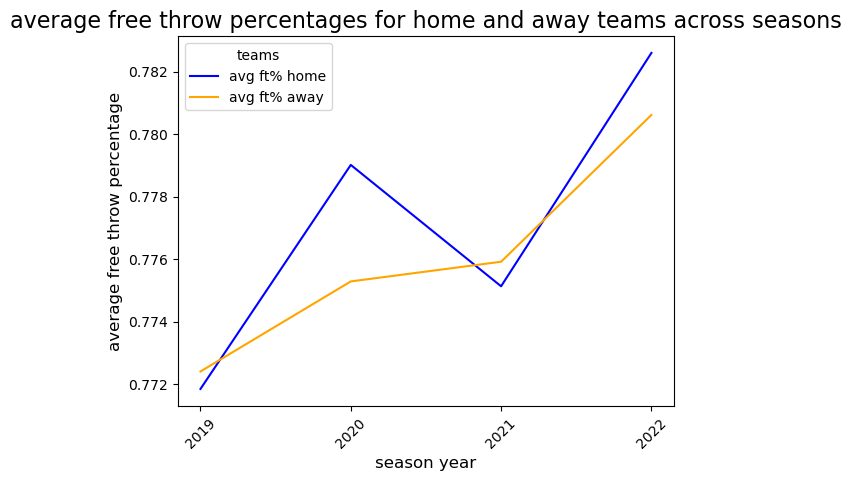

In [62]:
result = []
for year in seasons:
    ft_query = f"""
    SELECT 
        AVG(ft_pct_home) AS avg_ft_pct_home,
        AVG(ft_pct_away) AS avg_ft_pct_away
    FROM game
    WHERE SUBSTR(season_id, -4) = '{year}'
    """
    
    ft_data = pd.read_sql_query(ft_query, con)
    
    if not ft_data.empty:
        avg_ft_pct_home = ft_data['avg_ft_pct_home'][0]
        avg_ft_pct_away = ft_data['avg_ft_pct_away'][0]
        
        result.append({
            'season_year': year,
            'avg_ft_pct_home': avg_ft_pct_home,
            'avg_ft_pct_away': avg_ft_pct_away
        })

result_df = pd.DataFrame(result)
sns.lineplot(data=result_df, x='season_year', y='avg_ft_pct_home', label='avg ft% home', color='blue')
sns.lineplot(data=result_df, x='season_year', y='avg_ft_pct_away', label='avg ft% away', color='orange')

plt.xlabel('season year', fontsize=12)
plt.ylabel('average free throw percentage', fontsize=12)
plt.title('average free throw percentages for home and away teams across seasons', fontsize=16)
plt.legend(title='teams', loc='upper left')
plt.xticks(rotation=45)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\2743676113.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], rotation=45, fontsize=10)


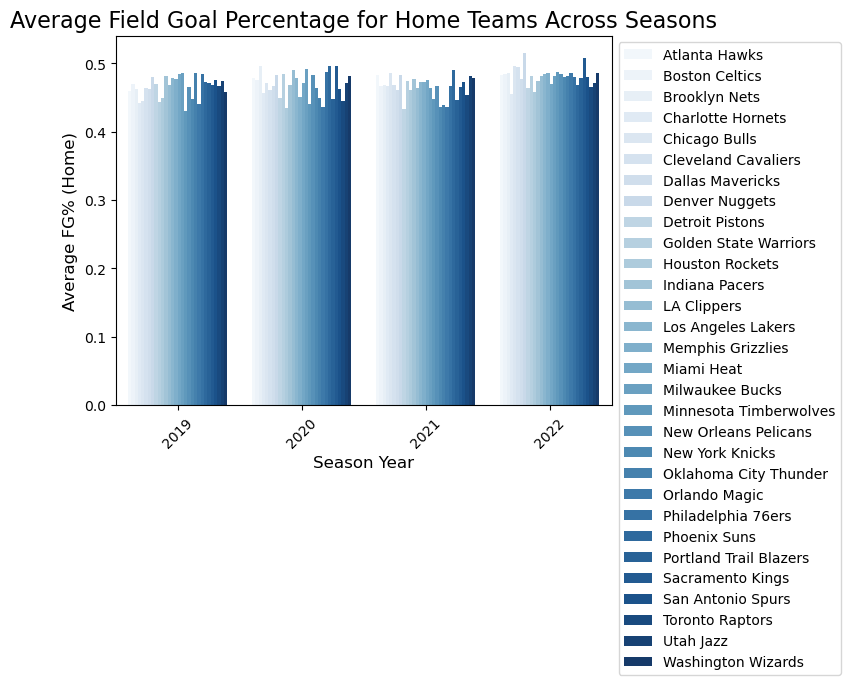

In [117]:
covid_fg_home = pd.read_sql_query("SELECT team_name_home, AVG(fg_pct_home), season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_home, season_id", con)
ax = sns.barplot(data=covid_fg_home, x='season_id', y='AVG(fg_pct_home)', hue='team_name_home', palette='Blues')
ax.set_xlabel('Season Year', fontsize=12)
ax.set_ylabel('Average FG% (Home)', fontsize=12)
ax.set_title('Average Field Goal Percentage for Home Teams Across Seasons', fontsize=16)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], rotation=45, fontsize=10)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1)) 
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\344291613.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019'], fontsize=10)


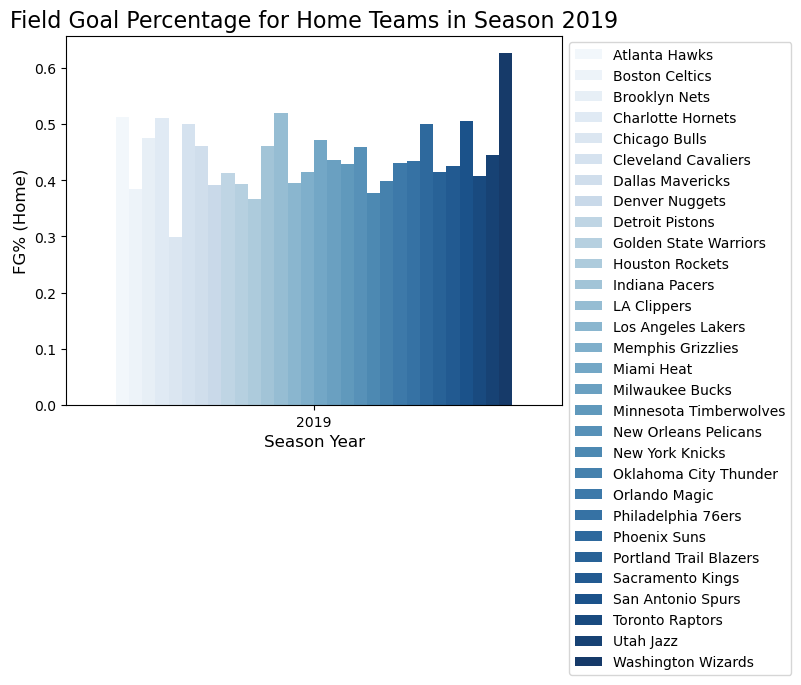

In [119]:
covid_fg_home = pd.read_sql_query("SELECT team_name_home, fg_pct_home, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_home, season_id", con)
ax = sns.barplot(data=covid_fg_home, x='season_id', y='fg_pct_home', hue='team_name_home', palette='Blues')
ax.set_xlabel('Season Year', fontsize=12)
ax.set_ylabel('FG% (Home)', fontsize=12)
ax.set_title('Field Goal Percentage for Home Teams in Season 2019', fontsize=16)
ax.set_xticklabels(['2019'], fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\502557559.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2020'], fontsize=10)


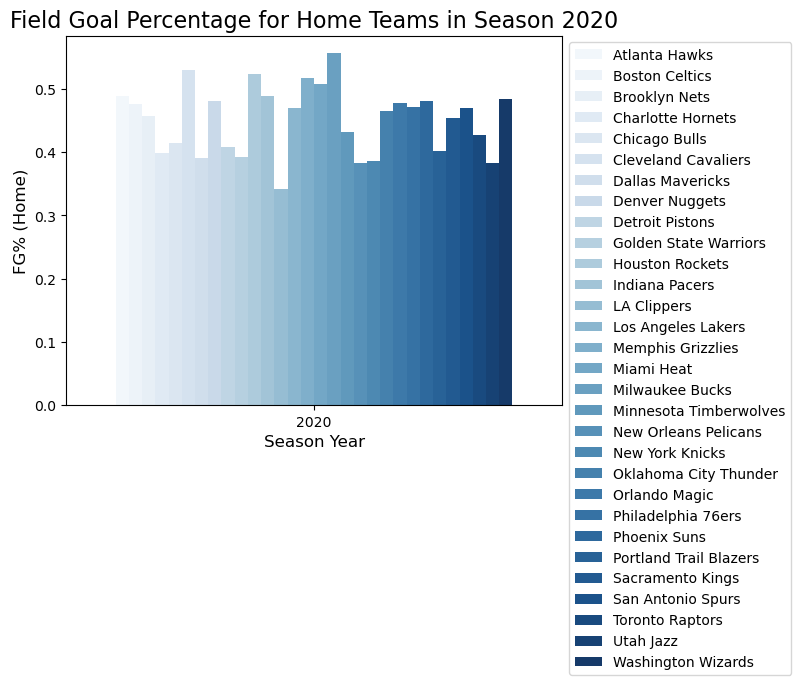

In [120]:
covid_fg_home = pd.read_sql_query("SELECT team_name_home, fg_pct_home, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_home, season_id", con)
ax = sns.barplot(data=covid_fg_home, x='season_id', y='fg_pct_home', hue='team_name_home', palette='Blues')
ax.set_xlabel('Season Year', fontsize=12)
ax.set_ylabel('FG% (Home)', fontsize=12)
ax.set_title('Field Goal Percentage for Home Teams in Season 2020', fontsize=16)
ax.set_xticklabels(['2020'], fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\2919148822.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)


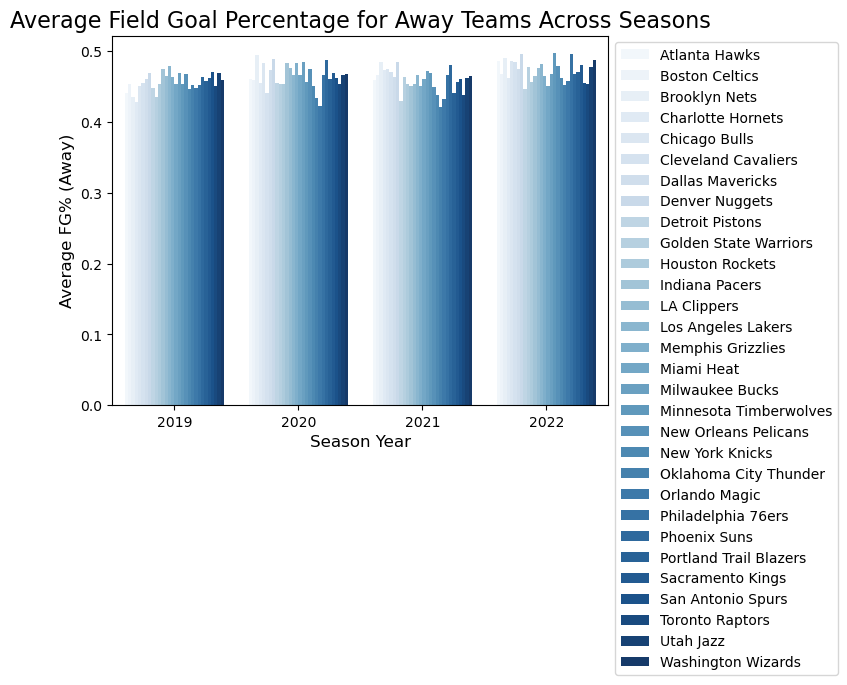

In [121]:
covid_fg_away = pd.read_sql_query("SELECT team_name_away, AVG(fg_pct_away), season_id FROM game WHERE season_id IN (22022, 22021, 22020, 22019) GROUP BY team_name_away, season_id", con)

ax = sns.barplot(data=covid_fg_away, x='season_id', y='AVG(fg_pct_away)', hue='team_name_away', palette='Blues')
ax.set_xlabel('Season Year', fontsize=12)
ax.set_ylabel('Average FG% (Away)', fontsize=12)
ax.set_title('Average Field Goal Percentage for Away Teams Across Seasons', fontsize=16)
ax.set_xticklabels(['2019', '2020', '2021', '2022'], fontsize=10)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\3703977920.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=covid_fg_away, x='team_name_away', y='fg_pct_away', palette='Blues')


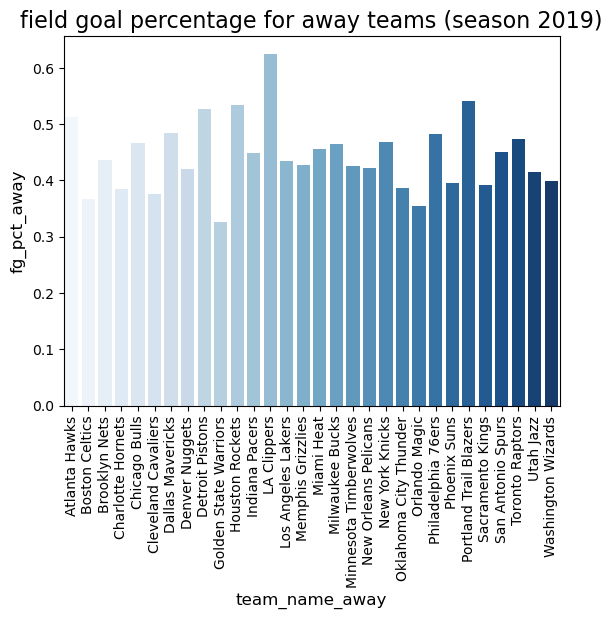

In [122]:
covid_fg_away = pd.read_sql_query("SELECT team_name_away, fg_pct_away, season_id FROM game WHERE season_id IN (22019) GROUP BY team_name_away, season_id", con)
sns.barplot(data=covid_fg_away, x='team_name_away', y='fg_pct_away', palette='Blues')
plt.xlabel('team_name_away', fontsize=12)
plt.ylabel('fg_pct_away', fontsize=12)
plt.title('field goal percentage for away teams (season 2019)', fontsize=16)
plt.xticks(rotation=90)
plt.show()

C:\Users\tsidd\AppData\Local\Temp\ipykernel_87508\1005915923.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=covid_fg_away, x='team_name_away', y='fg_pct_away', palette='Blues')


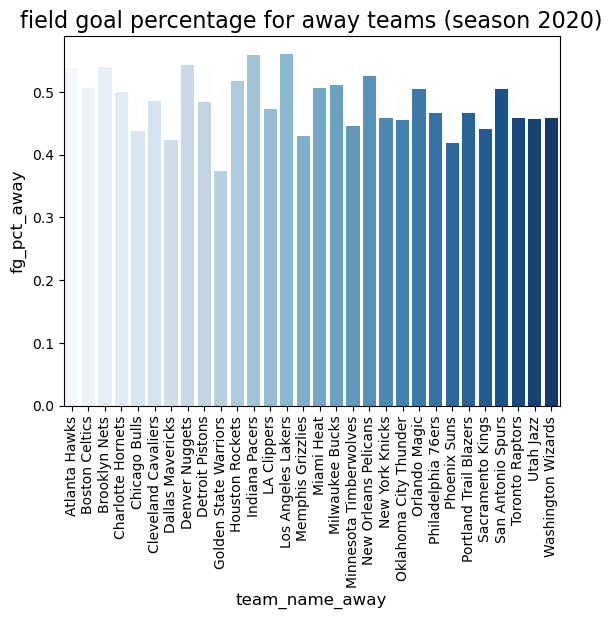

In [123]:
covid_fg_away = pd.read_sql_query("SELECT team_name_away, fg_pct_away, season_id FROM game WHERE season_id IN (22020) GROUP BY team_name_away, season_id", con)
sns.barplot(data=covid_fg_away, x='team_name_away', y='fg_pct_away', palette='Blues')
plt.xlabel('team_name_away', fontsize=12)
plt.ylabel('fg_pct_away', fontsize=12)
plt.title('field goal percentage for away teams (season 2020)', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [69]:
con.close()